Primeiramente importamos uns módulos útiles.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D
import time as time
from matplotlib import path
from matplotlib.path import Path
from tqdm import tqdm
import matlab.engine

t0 = time.perf_counter()

Inicializamos parámetros básicos.

In [2]:
n = 6
a = 10

max_in_sum_1 = 50 # Puntos para cada orde.
max_in_sum_2 = 50 # Ordes de F_n.

boundary = 'SQUARE'

Definimos unha función para determinar puntos dentro e fóra da máscara e o seu raio.

In [3]:
def pass_to_dB(function):
    return 10 * np.log10(function / np.max(function))

def clear_around(function, limit):
    function[np.where(function < limit)] = limit

def degrees(angle):
    return 180 * angle / np.pi

def radians(angle):
    return np.pi * angle / 180

def _ancho_(phi_rad_0):
    theta = 0
    
    for i in np.arange(1, 5): # Calculamos o ancho exacto a -0.50 dB.
        step = 10 / 8**i
        temp = 1
        
        while temp > 0:
            theta += step
            u = np.sin(radians(theta)) * np.cos(phi_rad_0)
            v = np.sin(radians(theta)) * np.sin(phi_rad_0)
            temp = mask_path.contains_point((u, v)) * 1 # 1 se o contén, 0 se non.
        
        theta -= step
    return np.sin(radians(theta))

def track_radio_mask(radio_0, sin_theta_0, mask, phi_rad):
    sin_theta_vector = np.zeros(len(phi_rad))
    
    for i in range(len(phi_rad)):
        sin_theta_vector[i] = _ancho_(phi_rad[i])
    
    return radio_0 * sin_theta_0 / sin_theta_vector

Procedemos ao cálculos coa máscara.

In [4]:
mask = np.loadtxt('mask_boundary_'+ boundary + '.dat')
mask_path = Path((mask))

radio_0 = 50 # Radio de 50 lambda.
sin_theta_0 = 0.04273

phi_deg = np.arange(-180, 180 + 0.1, 0.1)
phi_rad = np.pi * phi_deg / 180
radio_vector = track_radio_mask(radio_0, sin_theta_0, mask, phi_rad) # Creamos o vector radio.

Gardamos o raio vector para acceder a el dende Matlab.

In [5]:
np.savetxt('Temporal_radial_vector.txt', np.column_stack(radio_vector) / radio_0)

## Zeros de Bessel

In [6]:
rows = 2 * max_in_sum_2 + 1
columns = max_in_sum_1 + 1

Bessel_zeros = np.zeros((max_in_sum_2 + 1, columns))

for k in range(max_in_sum_2 + 1):
    Bessel_zeros[k, 1:max_in_sum_1 + 1] = sc.special.jn_zeros(k, max_in_sum_1) / np.pi

## Táboas de $F_n(p)$

$F_n$ é o que se calcula en Matlab.

In [7]:
Table_2 = True

if Table_2:
    eng = matlab.engine.start_matlab()    
    aux = np.zeros((rows, columns), dtype = 'complex')
    
    for k in tqdm(np.arange(- max_in_sum_2, max_in_sum_2 + 1)):        
        if k == 0:
            gamma_nm = Bessel_zeros[1, :]
        else:
            gamma_nm = Bessel_zeros[np.abs(k), :]
        
        for zero in range(columns):
            if gamma_nm[zero] in Bessel_zeros[1, :]:
                gamma_nm[zero] += 1e-5 # Cambiei esto de -15 a -5.
            
            try:
                aux[k + max_in_sum_2, zero] = eng.Integral(float(gamma_nm[zero]), float(k)) # Función de Matlab.
            except:
                eng.quit()
                eng = matlab.engine.start_matlab()
                aux[k + max_in_sum_2, zero] = eng.Integral(float(gamma_nm[zero]), float(k)) # Función de Matlab.
            
    np.savetxt('Results/Table_F_n_' + boundary + '.txt', aux)
    eng.quit()

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:37<00:00,  1.04it/s]


## Reconstruimos $F(\theta, \phi)$.

In [8]:
'''c = np.linspace(0, 10, 52)
c = np.delete(c, 0)

def F_reconstruction(x, y):
    phi = np.arctan(y, x)
    rho = np.sqrt(x**2 + y**2)
    
    for k in np.arange(- 50, 50 + 1):
        F_de_ns += F_k_loaded[k + 50, :] * np.exp(1j * k * phi)
    
    

x = np.arange(- np.pi / 2, np.pi / 2, 0.01)
X, Y = np.meshgrid(x, x)

N = len(x)
N_square = N * N

limit = -50
F_plot = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        F_plot[i, j] = F_reconstruction(X, Y)


Z = np.abs(F_reconstruction(X, Y))
Z = 2 * pass_to_dB(Z)
clear_around(Z, limit)
Z = np.reshape(Z, (N, N))



def F_k_comprobation(phi):
    F_de_ns = 0

    for k in np.arange(- 50, 50 + 1):
        F_de_ns += F_k_loaded[k + 50, :] * np.exp(1j * k * phi)

    F_de_ns = pass_to_dB(np.abs(F_de_ns))
    plt.plot(c, F_de_ns, label = u'$\phi = %.f$' %degrees(phi))
    plt.legend(loc = 'best')
    plt.ylim(-50, 0)
    plt.xlim(0, 10)
    #plt.show()

F_k_comprobation(radians(0))
F_k_comprobation(radians(15))
F_k_comprobation(radians(30))
F_k_comprobation(radians(45))
F_k_comprobation(radians(60))
F_k_comprobation(radians(90))'''

"c = np.linspace(0, 10, 52)\nc = np.delete(c, 0)\n\ndef F_reconstruction(x, y):\n    phi = np.arctan(y, x)\n    rho = np.sqrt(x**2 + y**2)\n    \n    for k in np.arange(- 50, 50 + 1):\n        F_de_ns += F_k_loaded[k + 50, :] * np.exp(1j * k * phi)\n    \n    \n\nx = np.arange(- np.pi / 2, np.pi / 2, 0.01)\nX, Y = np.meshgrid(x, x)\n\nN = len(x)\nN_square = N * N\n\nlimit = -50\nF_plot = np.zeros((N, N))\n\nfor i in range(N):\n    for j in range(N):\n        F_plot[i, j] = F_reconstruction(X, Y)\n\n\nZ = np.abs(F_reconstruction(X, Y))\nZ = 2 * pass_to_dB(Z)\nclear_around(Z, limit)\nZ = np.reshape(Z, (N, N))\n\n\n\ndef F_k_comprobation(phi):\n    F_de_ns = 0\n\n    for k in np.arange(- 50, 50 + 1):\n        F_de_ns += F_k_loaded[k + 50, :] * np.exp(1j * k * phi)\n\n    F_de_ns = pass_to_dB(np.abs(F_de_ns))\n    plt.plot(c, F_de_ns, label = u'$\\phi = %.f$' %degrees(phi))\n    plt.legend(loc = 'best')\n    plt.ylim(-50, 0)\n    plt.xlim(0, 10)\n    #plt.show()\n\nF_k_comprobation(radians

## Calculamos $g_n(p)$

In [9]:
if Table_2:
    F_k_loaded = aux
    
else:
    #F_k_loaded = np.loadtxt('F_n_SQUARE.dat', dtype = 'complex') # Cargamos as F_n de Aarón.
    F_k_loaded = np.loadtxt('Results/Table_F_n_' + boundary + '.txt', dtype = 'complex')

def g_n(k, rho): # Para todo n.
    aux = 0
    p = np.pi * rho / a
    
    if k == 0:
        for m in np.arange(0, max_in_sum_1):
            gamma_1m = Bessel_zeros[1, m]
            aux += (F_k_loaded[max_in_sum_2, m] * sc.special.jv(0, gamma_1m * p)) / (sc.special.jv(0, gamma_1m * np.pi))**2 
    
    else:
        for m in np.arange(1, max_in_sum_1):
            gamma_nm = Bessel_zeros[np.abs(k), m]
            aux -= (F_k_loaded[k + max_in_sum_2, m] * sc.special.jv(k, gamma_nm * p)) / (sc.special.jv(k - 1, gamma_nm * np.pi) * sc.special.jv(k + 1, gamma_nm * np.pi))
        
    return 2 * aux / np.pi**2

Representamos as g's.

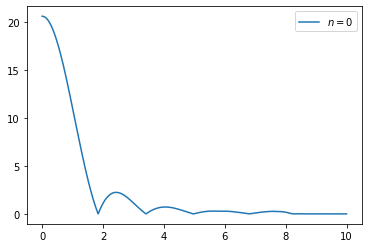

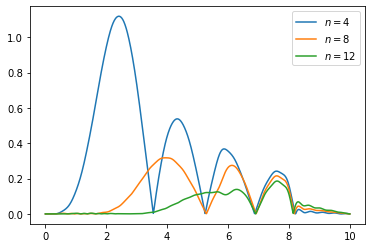

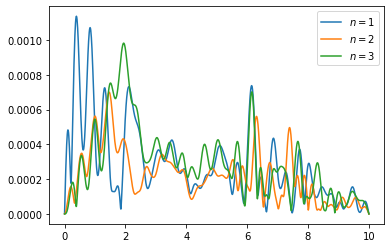

In [10]:
d = np.linspace(0, a, 1000, endpoint = True)

plt.plot(d, np.abs(g_n(0, d)), label = u'$n = %.f$' %0)
plt.legend(loc = 'best')

plt.show()

for k in [4, 8, 12]:
    plt.plot(d, np.abs(g_n(k, d)), label = u'$n = %.f$' %k)
    plt.legend(loc = 'best')

plt.show()

for k in [1, 2, 3]:
    plt.plot(d, np.abs(g_n(k, d)), label = u'$n = %.f$' %k)
    plt.legend(loc = 'best')

plt.show()

## Calculamos $K_n(\rho)$

In [11]:
def K_n(k, p):
    return g_n(k, p) * np.pi / (2 * a**2 * (1j)**k)

## Táboas de $K_n(\rho)$

In [12]:
Table_3 = True

radius_length = int((a + 0.5) / 0.01) + 1
radius = np.flip(np.linspace(a, 0, radius_length, endpoint = False))

if Table_3:
    _aux_ = np.zeros((2 * max_in_sum_2 + 1, radius_length), dtype = 'complex')

    for k in tqdm(np.arange(-max_in_sum_2, max_in_sum_2 + 1)):
        for j in range(radius_length):
            _aux_[k + max_in_sum_2, j] = K_n(k, radius[j])

    np.savetxt('Results/Table_K_n_a_' + str(a) + '_' + boundary + '.txt', _aux_)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:47<00:00,  1.06s/it]


## Calculamos $K(\rho, \beta)$

In [13]:
if Table_3:
    K_n_loaded = _aux_
    
else:
    K_n_loaded = np.loadtxt('Results/Table_K_n_a_10_' + boundary + '.txt', dtype = 'complex')

def find_nearest(array, value): # It returns the position.
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return int(idx)

def K_rho_beta(p, beta):
    _aux_ = 0 + 1j*0
    
    for k in np.arange(- max_in_sum_2, max_in_sum_2 + 1):
        idx = find_nearest(radius, p)
        _aux_ += K_n_loaded[k + max_in_sum_2, idx] * np.exp(1j * k * beta)
    
    return _aux_

## Discretizamos

A continuación discretizamos a antena para calcular as excitacións usando o método de valor media dos vértices do cadrado.

In [14]:
spacing = 0.5 # Cambiar a 0.1.
half_spacing = 0.5 * spacing

I_mn = []
I_x = []
I_y = []

sign_x = np.array([1, 1, -1, -1])
sign_y = np.array([1, -1, 1, -1])

limit = (np.int(a / spacing) + 0.5) * spacing

for y in tqdm(np.arange(- limit, limit + 1, spacing)):        
    for x in np.arange(- limit, limit + 1, spacing):
        r_ij = np.sqrt(x**2 + y**2)
        beta_ij = np.arctan2(y, x)
        m = int(1800 + round(10 * degrees(beta_ij)))

        if r_ij <= radio_vector[m]:
            aux = 0 + 1j*0

            for i in range(4):
                new_x = x + sign_x[i] * half_spacing
                new_y = y + sign_y[i] * half_spacing

                r_ij = np.sqrt(new_x**2 + new_y**2)
                beta_ij = np.arctan2(new_y, new_x)
                aux += K_rho_beta(r_ij, beta_ij)

            aux /= 4
            I_mn.append(aux)
            I_x.append(x)
            I_y.append(y)

I_mn /= np.max(I_mn)

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:09<00:00,  4.76it/s]


Como método de optimización eliminamos os elementos con excitación menor á establecida.

In [15]:
'''excitation_threeshold = 0.02
removable_elements = np.where(np.abs(I_mn) < excitation_threeshold)[0]

I_mn = np.delete(I_mn, removable_elements) # Optimizado
I_x = np.delete(I_x, removable_elements) # Optimizado
I_y = np.delete(I_y, removable_elements) # Optimizado'''

'excitation_threeshold = 0.02\nremovable_elements = np.where(np.abs(I_mn) < excitation_threeshold)[0]\n\nI_mn = np.delete(I_mn, removable_elements) # Optimizado\nI_x = np.delete(I_x, removable_elements) # Optimizado\nI_y = np.delete(I_y, removable_elements) # Optimizado'

## Rango dinámico

In [16]:
def dynamic_range(array):
    array = np.abs(array)
    return np.max(array) / np.min(array)

print('O rango dinámico é de: ', dynamic_range(I_mn))

O rango dinámico é de:  81109.06280261009


## Calculamos $F(\theta, \phi)$

In [17]:
def F_theta_phi(Rho, Phi):
    aux_2 = 0 + 1j*0
    
    for k in range(len(I_mn)):
        aux = Rho * (I_x[k] * np.cos(Phi) + I_y[k] * np.sin(Phi))
        aux_2 += I_mn[k] * np.exp(1j * 2 * np.pi * aux)
        
    return aux_2

Creamos o enreixado.

In [18]:
x = np.linspace(- 1, 1, 361, endpoint = True)
X, Y = np.meshgrid(x, x)

N = len(x)
N_square = N * N

rho = np.sqrt(X**2 + Y**2)
phi = np.arctan2(Y, X)

Rho = np.reshape(rho, (N_square))
Phi = np.reshape(phi, (N_square))

Calculamos os valores do patrón, limpámolo e xeramos a imaxe.

In [19]:
limit = -50
Z = np.abs(F_theta_phi(Rho, Phi))
Z = 2 * pass_to_dB(Z)
clear_around(Z, limit)
Z = np.reshape(Z, (N, N))

# A continuación limpamos o que está fóra dun raio de pi/2.

for i in range(N):
    for j in range(N):
        x_0 = i * np.pi/N - np.pi/2
        y_0 = j * np.pi/N - np.pi/2
        
        if np.square(x_0*x_0 + y_0*y_0) > np.pi/2:
            Z[i, j] = limit

Xeramos a imaxe e gardamos resultados.

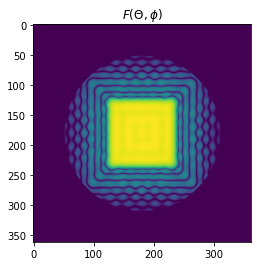

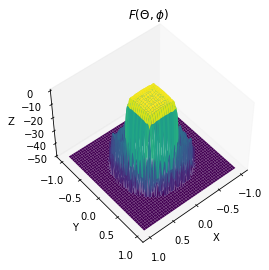

In [20]:
np.savetxt('Results/Data_F_' + boundary + '.txt', Z)

fig = plt.figure(1)
plt.imshow(Z) 
plt.title('$F(\Theta, \phi)$')
plt.savefig('Results/Horizontal_F_' + boundary + '.png', dpi = 300)

fig = plt.figure(2)
ax = plt.axes(projection = '3d')
ax.plot_surface(X, Y, Z, cmap = 'viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.grid(False)
ax.set_visible(True)
ax.set_zlim(limit, 0)
plt.title('$F(\Theta, \phi)$')
plt.savefig('Results/3D_F_' + boundary + '.png', dpi = 300)
ax.view_init(50, 50)

In [21]:
print('Total execution time is:', np.round(time.perf_counter() - t0, 2), 's')

Total execution time is: 241.71 s
